# Distributed Data Analytics
# Exercise Sheet 6
## Sebastian Pineda Arango Mtr. Nr. 246098

In this notebooks we are going to implement two Convolutional Neural Networks, a complex and simple one. Moreover, we are going to apply data transformations to increase the size of the training data. The models will be trained on CIFAR10 dataset [3].


### Data Augmentation

For the data augmentation process, we are going to implement the following transformations using Tensorflow:

- Scaling
- Translation
- Rotation

To code the transformations, we have partially taken references from [4] and [5].


In [1]:
import numpy as np
import tensorflow as tf
import keras
import math
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import os

%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


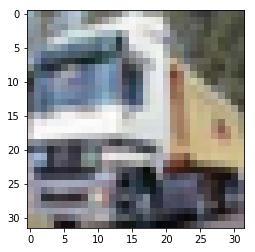

(50000, 32, 32, 3)


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_images = x_train.shape[0]
image_size = x_train.shape[1]
num_classes = np.max(y_train)+1

#loading image sample
plt.figure()
plt.imshow(x_train[1,:,:,:])
plt.show()
print(x_train.shape)

In [3]:
X = tf.placeholder(tf.uint8, shape = (None, image_size, image_size, 3))
y =  tf.placeholder(tf.uint8, shape=(None, 1), name='output_y')

class DataAugmentation():
    
    def __init__(self, image_size, num_images):
        
        """Contructur for the data augmentation class"""
        
        self.image_size = image_size
        self.num_images = num_images
        
        print("Creating Data Agumentation Class")
        
    def rotate(self, angle=30):
        
        """Rotation of the image"""
        
        rotate_tf =  tf.dtypes.cast(tf.contrib.image.rotate(self.X, angle), tf.uint8)
        self.rotate_tf = rotate_tf
        

    def scale(self, scale=0.8):
        
        """Scaling of the image"""

        n_imgs = self.num_images
        boxes = np.zeros((n_imgs, 4), dtype = np.float32)

        for index in range(n_imgs):
            x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
            x2 = y2 = 0.5 + 0.5 * scale
            boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
        box_ind = np.arange(n_imgs)
        crop_size = np.array([image_size, image_size], dtype = np.int32)
        scale_tf = tf.dtypes.cast(tf.image.crop_and_resize(self.X, boxes, box_ind, crop_size), tf.uint8)
        self.scale_tf = scale_tf
        
        
    def translate(self, pix_trans=10):
                
        """Translation of the image"""
        
        translate_tf = tf.dtypes.cast(tf.contrib.image.translate(self.X, translations=[5,5]),  tf.uint8)
        self.translate_tf = translate_tf

    def get_rotate(self):
        
        return self.rotate_tf
    
    def get_scale(self):
        
        return self.scale_tf
    
    def get_translate(self):
        
        return self.translate_tf
    
    def augment_data(self, X, y,  angle, scale, pix_trans):
        
        """Main function to augment the data"""
        
        angle_radians = np.pi*(angle/180) #transforming to radians
        self.X = X
        self.rotate(angle_radians)
        self.scale(scale)
        self.translate(pix_trans)
        
        return tf.concat([self.X, self.rotate_tf, self.scale_tf, self.translate_tf], axis=0), tf.concat([y, y, y, y], axis=0)
    
scale=0.9
pix_trans = 10
angle = 20
data_augmenter = DataAugmentation(image_size=image_size, num_images=num_images)
da_tensor, da_labels = data_augmenter.augment_data(X, y, angle, scale, pix_trans)

sess = tf.Session()

X_train_a, y_train_a, ex_rotate, ex_scale, ex_translate = sess.run([da_tensor, da_labels, data_augmenter.get_rotate()[0], 
                                           data_augmenter.get_scale()[0], data_augmenter.get_translate()[0]], 
                                            feed_dict= {X:x_train,
                                                        y: y_train})
sess.close()

Creating Data Agumentation Class

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
#checking the size after data augmentation
print(X_train_a.shape)
print(y_train_a.shape)

(200000, 32, 32, 3)
(200000, 1)


Original


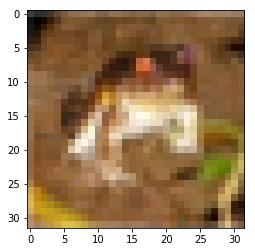

Example from rotation


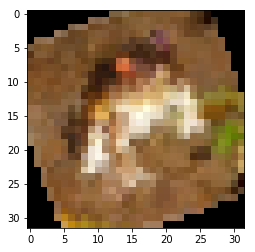

Example from scaling


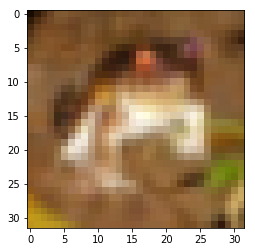

Example from translation


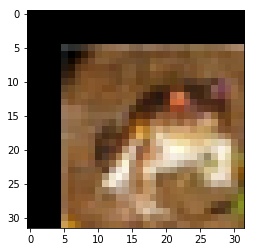

In [5]:
#checking data augmentation
plt.imshow(x_train[0,:,:,:])
print("Original")
plt.show()

plt.imshow(ex_rotate)
print("Example from rotation")
plt.show()

plt.imshow(ex_scale)
print("Example from scaling")
plt.show()

plt.imshow(ex_translate)
print("Example from translation")
plt.show()

### Simple convolutional network

We implement a simple neural network with only a convolutional layer, a max-pooling layer and a fully connected layer. For *regularizing* the neural network, there are several techniques:

- Data augmentation: it is, generating new images by transforming the original training images (as we have done before)
- Drop-out: by eliminating, randomly, some activations.
- Batch-normalization: which has been reported to have a normalizing effect [6].
- L2 (or L1) normalization: by penalizing the weights magnitude in the loss function.

In the following examples we are goning to apply L2 (in the simple model) and Batch Normalization (in the complex model).

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """ 
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[ permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[ k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [9]:
#simple scaling of inputs: limiting the data due to RAM usage issues
X_train = X_train_a[:20000]/255
X_test = x_test/255
y_train = y_train_a[:20000]
y_test = y_test

In [10]:
#transforming labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
#initializing the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

conv_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 1], mean=0, stddev=0.1))
W = tf.Variable(tf.truncated_normal(shape=[64, num_classes], mean=0, stddev=0.1))
bias = tf.Variable(tf.truncated_normal(shape=[num_classes], mean=0, stddev=0.1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#hyperpameters
learning_rate = 1e-3
num_epochs = 30
batch_size = 128
reg_weight =  0.001

#defining the graph
conv1 = tf.nn.conv2d(x, conv_filter, strides=[1,2,2,1], padding='SAME', name="conv1")
activ1 = tf.nn.relu(conv1)
pool = tf.nn.max_pool(activ1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
flat = tf.contrib.layers.flatten(pool)
output = tf.nn.relu(tf.matmul(flat, W) +bias)

regularizer = tf.nn.l2_loss(W) + tf.nn.l2_loss(conv1) 

#defintion of loss function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output)) + reg_weight*regularizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

acc_test_list = []
acc_train_list = []
acc_train_list_ = []

#suscribing tensor to tensorboard
with tf.name_scope('conv1'):
    variable_summaries(conv1)

with tf.name_scope('W'):
    variable_summaries(W)

with tf.name_scope('performance'):
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cost', cost)

#running the graph
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    summ_writer_train = tf.summary.FileWriter(os.path.join('summaries_simple','train'), sess.graph)
    summ_writer_test = tf.summary.FileWriter(os.path.join('summaries_simple','test'), sess.graph)
    
    merged = tf.summary.merge_all()
    
    for epoch in range(num_epochs):
        minibatches = random_mini_batches(X_train, y_train, batch_size, 1)
        list_acc_ = []
        
        for i, minibatch in enumerate(minibatches):
            batch_X, batch_y = minibatch
            
            _, cost_, acc_ = sess.run([optimizer, cost, accuracy],
                                     feed_dict = {x: batch_X,
                                                  y: batch_y})
            list_acc_.append(acc_)

        
        summ_test, acc_test = sess.run([merged, accuracy], feed_dict = {x: X_test,
                                                  y: y_test})
        summ_train, acc_train = sess.run([merged, accuracy], feed_dict = {x: X_train[:10000,:],
                                                  y: y_train[:10000,:]})
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        acc_train_list_.append(np.mean(list_acc_))
        
        print("Accuracy train:", acc_train)
        print("Accuracy test:", acc_test)
        
        summ_writer_train.add_summary(summ_train, epoch)
        summ_writer_test.add_summary(summ_test, epoch)
        summ_writer_train.flush()
        summ_writer_test.flush()

Accuracy train: 0.0974
Accuracy test: 0.1
Accuracy train: 0.1006
Accuracy test: 0.1018
Accuracy train: 0.1626
Accuracy test: 0.1632
Accuracy train: 0.1909
Accuracy test: 0.1818
Accuracy train: 0.1981
Accuracy test: 0.1947
Accuracy train: 0.201
Accuracy test: 0.199
Accuracy train: 0.2069
Accuracy test: 0.2012
Accuracy train: 0.2115
Accuracy test: 0.2046
Accuracy train: 0.2152
Accuracy test: 0.2064
Accuracy train: 0.2111
Accuracy test: 0.2014
Accuracy train: 0.2178
Accuracy test: 0.2097
Accuracy train: 0.2198
Accuracy test: 0.2117
Accuracy train: 0.2206
Accuracy test: 0.2143
Accuracy train: 0.2218
Accuracy test: 0.2151
Accuracy train: 0.2207
Accuracy test: 0.2111
Accuracy train: 0.2226
Accuracy test: 0.2146
Accuracy train: 0.225
Accuracy test: 0.217
Accuracy train: 0.223
Accuracy test: 0.2136
Accuracy train: 0.222
Accuracy test: 0.2112
Accuracy train: 0.2231
Accuracy test: 0.2135
Accuracy train: 0.2204
Accuracy test: 0.2115
Accuracy train: 0.2219
Accuracy test: 0.2126
Accuracy train: 0.2

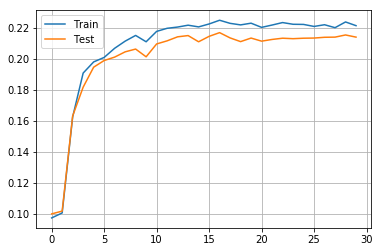

In [15]:
plt.plot(acc_train_list)
plt.plot(acc_test_list)
plt.grid()
plt.legend(("Train", "Test"))

### More complex network

Now we run a more complex network (with two convolutional layers nad two fully connected layers). We also change the activation function: instead of using ReLU, we use SeLU. We see that we achieved better results, however, the network can be further trained (with the full training set). We limit the training set due to RAM memory usage issues in the personal computer and in colaboratory.

In [21]:
#defining the graph
tf.reset_default_graph()

#placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

#variables
conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 5], mean=0, stddev=0.1))
conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 10], mean=0, stddev=0.1))

W1 = tf.Variable(tf.truncated_normal(shape=[640, 100], mean=0, stddev=0.1))
bias1 = tf.Variable(tf.truncated_normal(shape=[1, 100], mean=0, stddev=0.1))

W2 = tf.Variable(tf.truncated_normal(shape=[100, num_classes], mean=0, stddev=0.1))
bias2 = tf.Variable(tf.truncated_normal(shape=[num_classes], mean=0, stddev=0.1))

#first convolutional layer
conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME', name="conv1")
conv1_bn = tf.layers.batch_normalization(conv1)
conv1_a = tf.nn.selu(conv1_bn)
conv1_pool = tf.nn.max_pool(conv1_a, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

#second convolutional layer
conv2 = tf.nn.conv2d(conv1_pool, conv2_filter, strides=[1,1,1,1], padding='SAME', name="conv12")
conv2_bn = tf.layers.batch_normalization(conv2)
conv2_a = tf.nn.selu(conv2_bn)
conv2_pool = tf.nn.max_pool(conv2_a, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

#fully connected layers
flat = tf.contrib.layers.flatten(conv2_pool)  
fc1 = tf.matmul(flat, W1) +  bias1
fc1_bn = tf.layers.batch_normalization(fc1)
fc1_a = tf.nn.selu(fc1_bn)


output = tf.matmul(fc1_a, W2) + bias2


In [22]:
learning_rate = 1e-3
num_epochs = 40
batch_size = 128
reg_weight =  0.0001

#defining cost function and optimizer
regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(conv1) 
                                                    + tf.nn.l2_loss(conv2) 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= y, 
                                                              logits=output)) 
                                                        + reg_weight*regularizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#susbcribing tensors to tensorboard
with tf.name_scope('conv1'):
    variable_summaries(conv1)
    
with tf.name_scope('conv2'):
    variable_summaries(conv2)
    
with tf.name_scope('W1'):
    variable_summaries(W1)

with tf.name_scope('W2'):
    variable_summaries(W2)

with tf.name_scope('performance'):
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cost', cost)

acc_test_list = []
acc_train_list = []
acc_train_list_ = []

#running the graph
with tf.Session() as sess:
    
    #initialinzg graph
    sess.run(tf.global_variables_initializer())
    
    summ_writer_train = tf.summary.FileWriter(os.path.join('summaries_complex','train'), sess.graph)
    summ_writer_test = tf.summary.FileWriter(os.path.join('summaries_complex','test'), sess.graph)

    merged = tf.summary.merge_all()
    
    #iterations over epochs
    for epoch in range(num_epochs):
        
        minibatches = random_mini_batches(X_train, y_train, batch_size, 1)
        list_acc_ = []
        for i, minibatch in enumerate(minibatches):
            batch_X, batch_y = minibatch
            
            _, cost_, acc_ = sess.run([optimizer, cost, accuracy],
                                     feed_dict = {x: batch_X,
                                                  y: batch_y})
            
            list_acc_.append(acc_)

        #computing the accuracy
        summ_test, acc_test = sess.run([merged, accuracy], feed_dict = {x: X_test,
                                                  y: y_test})
        summ_train, acc_train = sess.run([merged, accuracy], feed_dict = {x: X_train[:10000,:],
                                                  y: y_train[:10000,:]})
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        acc_train_list_.append(np.mean(list_acc_))
        
        #printing the accuracy
        print("Epoch ", epoch)
        print("Accuracy train:", acc_train)
        print("Accuracy test:", acc_test)
        
        summ_writer_train.add_summary(summ_train, epoch)
        summ_writer_test.add_summary(summ_test, epoch)
        summ_writer_train.flush()
        summ_writer_test.flush()

Epoch  0
Accuracy train: 0.3135
Accuracy test: 0.3164
Epoch  1
Accuracy train: 0.4092
Accuracy test: 0.4006
Epoch  2
Accuracy train: 0.4446
Accuracy test: 0.4329
Epoch  3
Accuracy train: 0.4476
Accuracy test: 0.4365
Epoch  4
Accuracy train: 0.4687
Accuracy test: 0.4506
Epoch  5
Accuracy train: 0.4756
Accuracy test: 0.4559
Epoch  6
Accuracy train: 0.488
Accuracy test: 0.4595
Epoch  7
Accuracy train: 0.5159
Accuracy test: 0.4803
Epoch  8
Accuracy train: 0.5319
Accuracy test: 0.4882
Epoch  9
Accuracy train: 0.5488
Accuracy test: 0.4988
Epoch  10
Accuracy train: 0.5622
Accuracy test: 0.509
Epoch  11
Accuracy train: 0.565
Accuracy test: 0.5103
Epoch  12
Accuracy train: 0.5845
Accuracy test: 0.5188
Epoch  13
Accuracy train: 0.574
Accuracy test: 0.5109
Epoch  14
Accuracy train: 0.5884
Accuracy test: 0.5186
Epoch  15
Accuracy train: 0.5844
Accuracy test: 0.5135
Epoch  16
Accuracy train: 0.5918
Accuracy test: 0.5184
Epoch  17
Accuracy train: 0.6023
Accuracy test: 0.5252
Epoch  18
Accuracy train

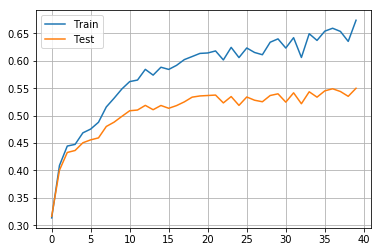

In [23]:
plt.plot(acc_train_list)
plt.plot(acc_test_list)
plt.grid()
plt.legend(("Train", "Test"))

### References

[1] Code from Minibatches taken from: https://github.com/andersy005/deep-learning-specialization-coursera/blob/master/02-Improving-Deep-Neural-Networks/week3/Programming-Assignments/tf_utils.py

[2] Tensorboard: https://www.tensorflow.org/guide/summaries_and_tensorboard

[3] CIFAR 10: https://www.cs.utoronto.ca/~kriz/cifar.html

[4] Data augmentation in Tensorflow (Source 1): http://androidkt.com/tensorflow-image-augmentation-using-tf-image/

[5] Data augmentation in Tensorflow (Source 2): https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9

[6] Sergey Ioffe and Christin Szegedy: "Batch Normalization: Accelerating Deep Netowrk Training by Reducing Internal Covariance Shift" (Available in: https://arxiv.org/pdf/1502.03167v3.pdf).